# Echoregions Regions2D Plotting and Masking Demonstration

Prior to running this notebook and all other notebooks, make sure you have installed the packages found in `requirements.txt`.

This notebook demonstrates some of the functionalities of `echoregions` to read Echoview region `.evr` files and visualize regions.

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import echoregions as er
import warnings
import urllib.request
import gdown

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# download an example file
urllib.request.urlretrieve("https://raw.githubusercontent.com/OSOceanAcoustics/echoregions/main/echoregions/test_data/x1.evr","x1.evr")

In [3]:
EVR_FILE = 'x1.evr'

### Get a Regions2D object with `read_evr`

In [4]:
r2d = er.read_evr(EVR_FILE)

## Plotting

In [5]:
# Display availible regions
r2d.data.region_id.values

<IntegerArray>
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35]
Length: 33, dtype: Int64

In [6]:
# let's select one id
region_ids = [11]

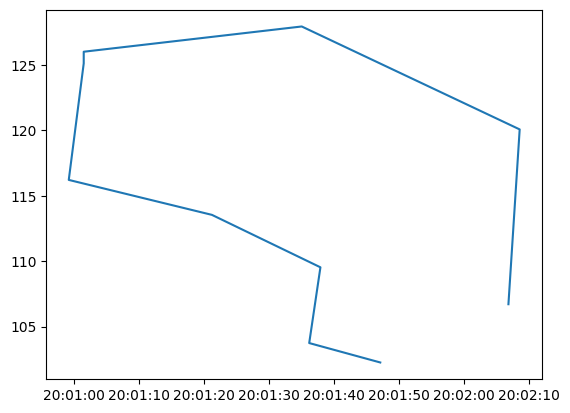

In [7]:
# Plot a region with a specific id with the `plot` function
r2d.plot(region_ids[0])

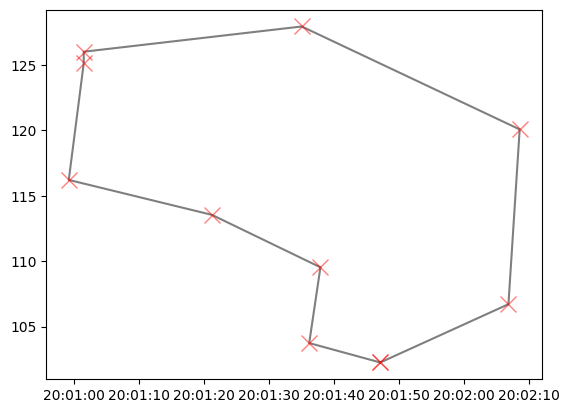

In [8]:
# Plot a closed region by using close_region=True.
# Optionally provide matplotlib kwargs for more customization.
r2d.plot(region_ids[0], close_region=True, color='k', alpha=.5, marker='x', markeredgecolor='red', markersize=12)

In [9]:
r2d.select_region(region_ids)

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
10,x1,EVRG,7,12.0.341.42620,11,13,10,0,2,-1,...,2017-06-25 20:02:08.535700,102.255201,127.947603,Unknown,1,Chicken nugget,"[2017-06-25T20:01:47.093000000, 2017-06-25T20:...","[102.2552007996, 103.7403107496, 109.532239554...",[],[]


## Plotting regions on an echogram

#### Reading Preprocessed Sonar Files

We have converted and calibrated the echosounder files corresponding to one transect and stored them in `.zarr`. We can directly read them with the `xarray` library. 

In [10]:
# mounting the google drive (uncomment if you have permission to read directly from Google Drive)
# from google.colab import drive
# drive.mount('/content/drive/') 

In [11]:
# Paths for Google Drive read  (uncomment if you have permission to read directly from Google Drive)
# ZARR_PATH = '/content/drive/Shareddrives/uw-echospace/shared_data/SH1707/x1.zarr'

In [13]:
# download a zipped sample folder from publicly available Google Drive
url = 'https://drive.google.com/uc?id=1OhYVcakCEgXEKA4R9za4jvBWQUFIOnE5'
output = 'x1.tar.gz'
gdown.download(url, output, quiet=False)

In [ ]:
# Unzip into a sample folder
!tar -xvzf  x1.tar.gz

tar: Error opening archive: Failed to open 'x1.tar.gz'


In [ ]:
ds = xr.open_dataset("x1.zarr")

c:\Users\cmtug\OneDrive\Documents\GitHub\echoregions\.conda\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\cmtug\OneDrive\Documents\GitHub\echoregions\.conda\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\cmtug\OneDrive\Documents\GitHub\echoregions\.conda\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [ ]:
ds

<xarray.Dataset>
Dimensions:                (channel: 3, ping_time: 13192, range_sample: 3957)
Coordinates:
  * channel                (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES1...
  * ping_time              (ping_time) datetime64[ns] 2017-06-25T15:04:30.076...
  * range_sample           (range_sample) int64 0 1 2 3 ... 3953 3954 3955 3956
Data variables: (12/13)
    Sv                     (channel, ping_time, range_sample) float64 ...
    depth                  (channel, ping_time, range_sample) float64 ...
    echo_range             (channel, ping_time, range_sample) float64 ...
    equivalent_beam_angle  (channel) float64 ...
    frequency_nominal      (channel) float64 ...
    gain_correction        (channel) float64 ...
    ...                     ...
    sa_correction          (channel) float64 ...
    salinity               float64 ...
    sound_absorption       (channel, ping_time) float64 ...
    sound_speed            (channel, ping_time) float64 ...
    temperature            float64 ...
    water_level            (channel, ping_time) float64 ...

The dataset has a `range_sample` dimension and instead we convert it to a `depth` dimension by adjusting the water level.

In [ ]:
# create depth coordinate:
echo_range = ds.echo_range.isel(channel=0, ping_time=0)
# assuming water levels are same for different frequencies and location_time
depth = ds.water_level.isel(channel=0, ping_time=0) + echo_range
depth = depth.drop_vars('channel')
# creating a new depth dimension
ds['depth'] = depth
ds = ds.swap_dims({'range_sample': 'depth'})

In [ ]:
ds

<xarray.Dataset>
Dimensions:                (channel: 3, ping_time: 13192, depth: 3957)
Coordinates:
  * channel                (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES1...
  * depth                  (depth) float64 9.15 9.15 9.15 ... 758.1 758.3 758.5
  * ping_time              (ping_time) datetime64[ns] 2017-06-25T15:04:30.076...
    range_sample           (depth) int64 0 1 2 3 4 ... 3952 3953 3954 3955 3956
Data variables:
    Sv                     (channel, ping_time, depth) float64 ...
    echo_range             (channel, ping_time, depth) float64 ...
    equivalent_beam_angle  (channel) float64 ...
    frequency_nominal      (channel) float64 ...
    gain_correction        (channel) float64 ...
    pressure               float64 ...
    sa_correction          (channel) float64 ...
    salinity               float64 ...
    sound_absorption       (channel, ping_time) float64 ...
    sound_speed            (channel, ping_time) float64 ...
    temperature            float64 ...
    water_level            (channel, ping_time) float64 ...

In [ ]:
# set the min and max depth based on the sonar files
r2d.min_depth = ds.depth.min()
r2d.max_depth = ds.depth.max()

In [ ]:
r2d.select_region(region_ids[0])

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
10,x1,EVRG,7,12.0.341.42620,11,13,10,0,2,-1,...,2017-06-25 20:02:08.535700,102.255201,127.947603,Unknown,1,Chicken nugget,"[2017-06-25T20:01:47.093000000, 2017-06-25T20:...","[102.2552007996, 103.7403107496, 109.532239554...",[],[]


In [ ]:
region_df = r2d.select_region(region_ids)

In [ ]:
region_df

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
10,x1,EVRG,7,12.0.341.42620,11,13,10,0,2,-1,...,2017-06-25 20:02:08.535700,102.255201,127.947603,Unknown,1,Chicken nugget,"[2017-06-25T20:01:47.093000000, 2017-06-25T20:...","[102.2552007996, 103.7403107496, 109.532239554...",[],[]


In [ ]:
region_ids

[11]

In [ ]:
M = r2d.mask(ds.Sv.isel(channel=0).drop('channel'), region_ids, mask_var="ROI")

In [ ]:
# the mask has nan's where outside of the region
M.shape

(3957, 13192)

In [ ]:
# the region is labeled by default with 0 (if there are more regions they will be labeled 1,2,3,...)
M.max()

<xarray.DataArray 'ROI' ()>
array(0.)

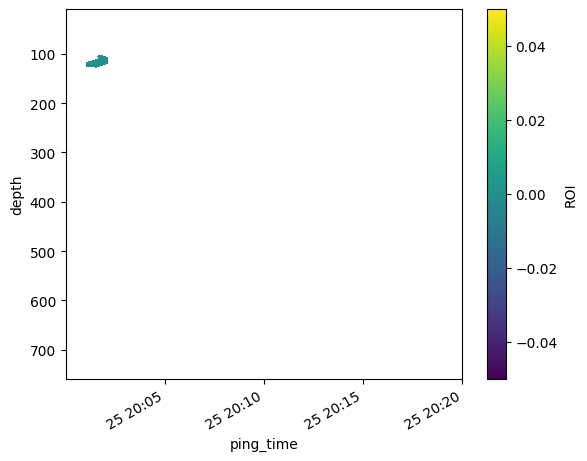

In [ ]:
# M.plot(yincrease=False)
# r2d.plot(region_ids, close_region=True, color='r')
M.sel(ping_time=slice('2017-06-25T20:00:00', '2017-06-25T20:20:00')).plot(yincrease=False)

We can also create a masked sonar file:

In [ ]:
Sv_masked = ds.Sv.where(~M.isnull())

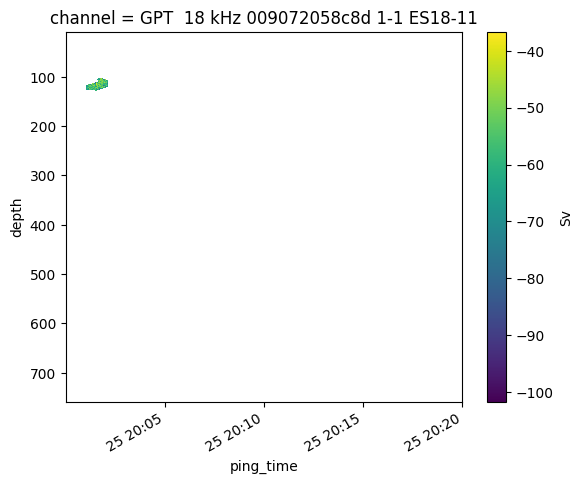

In [ ]:
# we limit the time range so that we see the small region
Sv_masked.sel(ping_time=slice('2017-06-25T20:00:00', '2017-06-25T20:20:00')).isel(channel=0).T.plot(yincrease=False)

#### Multiple Region Mask

The `mask` function can make a mask for several regions simultaneously:

In [ ]:
region_ids = [10, 11]

In [ ]:
r2d.select_region(region_ids)

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
9,x1,EVRG,7,12.0.341.42620,10,13,4,0,4,-1,...,2017-06-25 19:13:12.607500,9.244758,758.973217,Side station,0,Region10,"[2017-06-25T17:57:09.687500000, 2017-06-25T17:...","[9.2447583998, 758.9732173069, 758.9732173069,...",[],[]
10,x1,EVRG,7,12.0.341.42620,11,13,10,0,2,-1,...,2017-06-25 20:02:08.535700,102.255201,127.947603,Unknown,1,Chicken nugget,"[2017-06-25T20:01:47.093000000, 2017-06-25T20:...","[102.2552007996, 103.7403107496, 109.532239554...",[],[]


In [ ]:
r2d.data['time'][10].min()

numpy.datetime64('2017-06-25T20:00:59.180700000')

In [ ]:
r2d.data['time'][10].max()

numpy.datetime64('2017-06-25T20:02:08.535700000')

In [ ]:
M = r2d.mask(ds.Sv.isel(channel=0).drop('channel'), region_ids, mask_var="ROI")

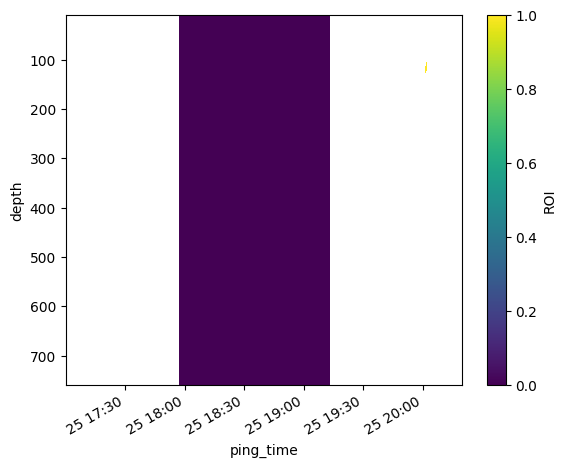

In [ ]:
# select range so that we see the regions
M.sel(ping_time=slice('2017-06-25T17:00:00', '2017-06-25T20:20:00')).plot(yincrease=False)

In [ ]:
# now the mask has labeled the regions 0 and 1, and rest is nan
np.unique(M.data)

array([ 0.,  1., nan])

If one wants to label the regions with explicit values they can pass them through the `mask_labels` variable as a list of integers.

In [ ]:
M = r2d.mask(ds.Sv.isel(channel=0).drop('channel'), region_ids, mask_var="ROI", mask_labels=[1, 1])

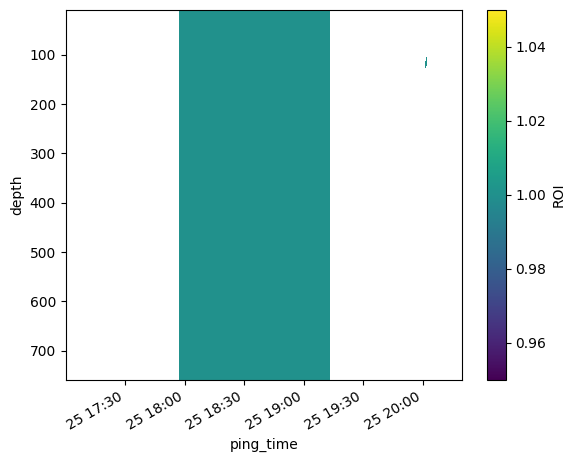

In [ ]:
# select range so that we see the regions
M.sel(ping_time=slice('2017-06-25T17:00:00', '2017-06-25T20:20:00')).plot(yincrease=False)

Alternatively, one could use the default ids from the `.evr` files.

In [ ]:
M = r2d.mask(ds.Sv.isel(channel=0).drop('channel'), region_ids, mask_var="ROI", mask_labels="from_ids")

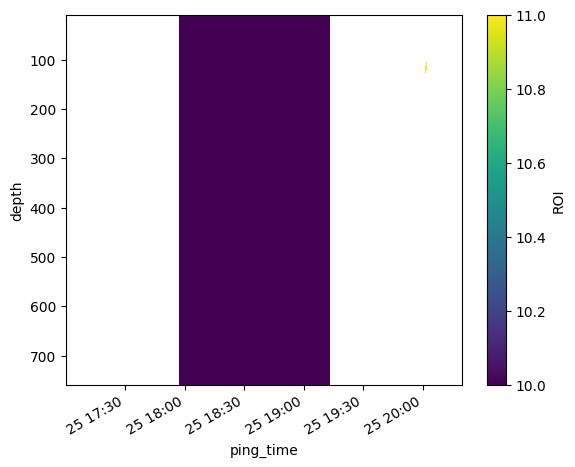

In [ ]:
# select range so that we see the regions
M.sel(ping_time=slice('2017-06-25T17:00:00', '2017-06-25T20:20:00')).plot(yincrease=False)